# Ejercicio 4

Queremos cuantificar la __asortatividad__ de las redes _netscience_ y _as-22july06_ (de acá en adelante _july_). Para ello, exploraremos el _coeficiente de correlación ($r$)_ y la distribución del _promedio del grado de los primeros vecinos ($K_{nn}$)_

In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from func4 import *
%matplotlib notebook


## Load data

netscience = nx.read_gml('TC01_data/netscience.gml')
july = nx.read_gml('TC01_data/as-22july06.gml')

### Nearest neighbor degree $K_{nn}$
Definimos la función *nearest_nei(graph)*, que recorre la red buscando nodos con un dado grado (hasta el grado máximo de la red) y calcula el grado medio de sus vecinos. Finalmente devuelve el promedio de la cantidad anterior calculada para los nodos con un cierto grado en comun, y los grados hallados en la red.

In [2]:
def nearest_nei(graph):
    k_vecinos = []                      #Grado medio de los vecinos para un k
    k = []                              #Grados de los nodos
    deg = 1                             #Grado de los nodos que recorro
    while deg <= max(degrees(graph, node='All')):
        
        mismo_k = 0                     #Grado medio acumulado para un k
        m = 0                           #Número de nodos con ese k
        
        for n in list(graph.nodes()):
            
            if degrees(graph, node=n) == deg:
                deg_n = 0               #Grado medio acumulado para un nodo
                ed = list(graph.neighbors(n))  #Lista de vecinos de un nodo
                
                for i in ed:
                    deg_n += degrees(graph, node=i)
                    
                deg_n =deg_n/deg        #Valor medio del grado para un nodo
                mismo_k += deg_n        #Suma ese valor medio al grado acumulado para un k
                m+=1                    #Cuenta el nodo como perteneciente a cierto k
                
        #Recorre la lista de nodos, si hay nodos con ese grado, los appendea.
        if m != 0:
            k_vecinos.append(mismo_k/m)
            k.append(deg)           #Guardo el grado de los nodos
                
        #Cambia de grado
        deg += 1
    return k_vecinos, k


knn_net, k_net = nearest_nei(netscience)
knn_july, k_july = nearest_nei(july)

Después encontramos que esta función ya estaba definida (dos veces) en la librería networkx.  
La cantidad $k_{nn}$, está modelada en función del grado $k$ como una ley de potencias:
$k_{nn}(k) = Ck^{ \mu}$. Los siguientes gráficos presenta la cantidad $k_{nn}$ para ambas redes, con el correspondiente ajuste. 

In [3]:
##### Funciones definidas para el ajuste en func4.py #####
from scipy import optimize

powerlaw = lambda x, C, a: C*(x**a)

#Calculamos los parámetros del ajuste para nuestras redes

C_net, a_net, a_err_net = powerlaw_fit(k_net[:9], knn_net[:9], p0 = [-2,2])
C_july, a_july, a_err_july = powerlaw_fit(k_july, knn_july, p0 = [-2,2])

#Valores sobre los que voy a aplicar el ajuste
ejex_net = np.linspace(k_net[0],k_net[-1],num=50)
ejex_july = np.linspace(k_july[0],k_july[-1],num=50)


<IPython.core.display.Javascript object>


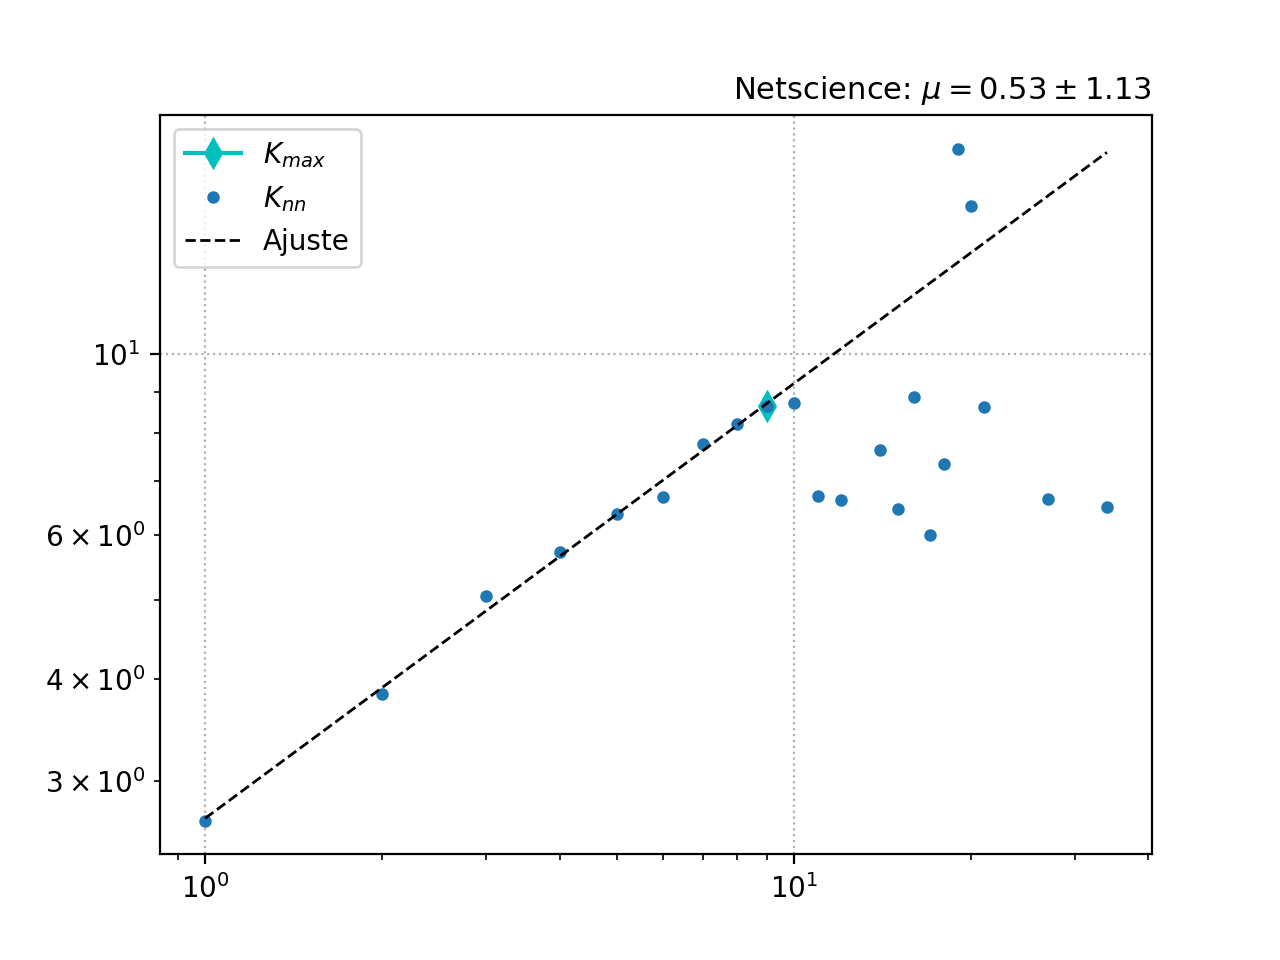

<IPython.core.display.Javascript object>


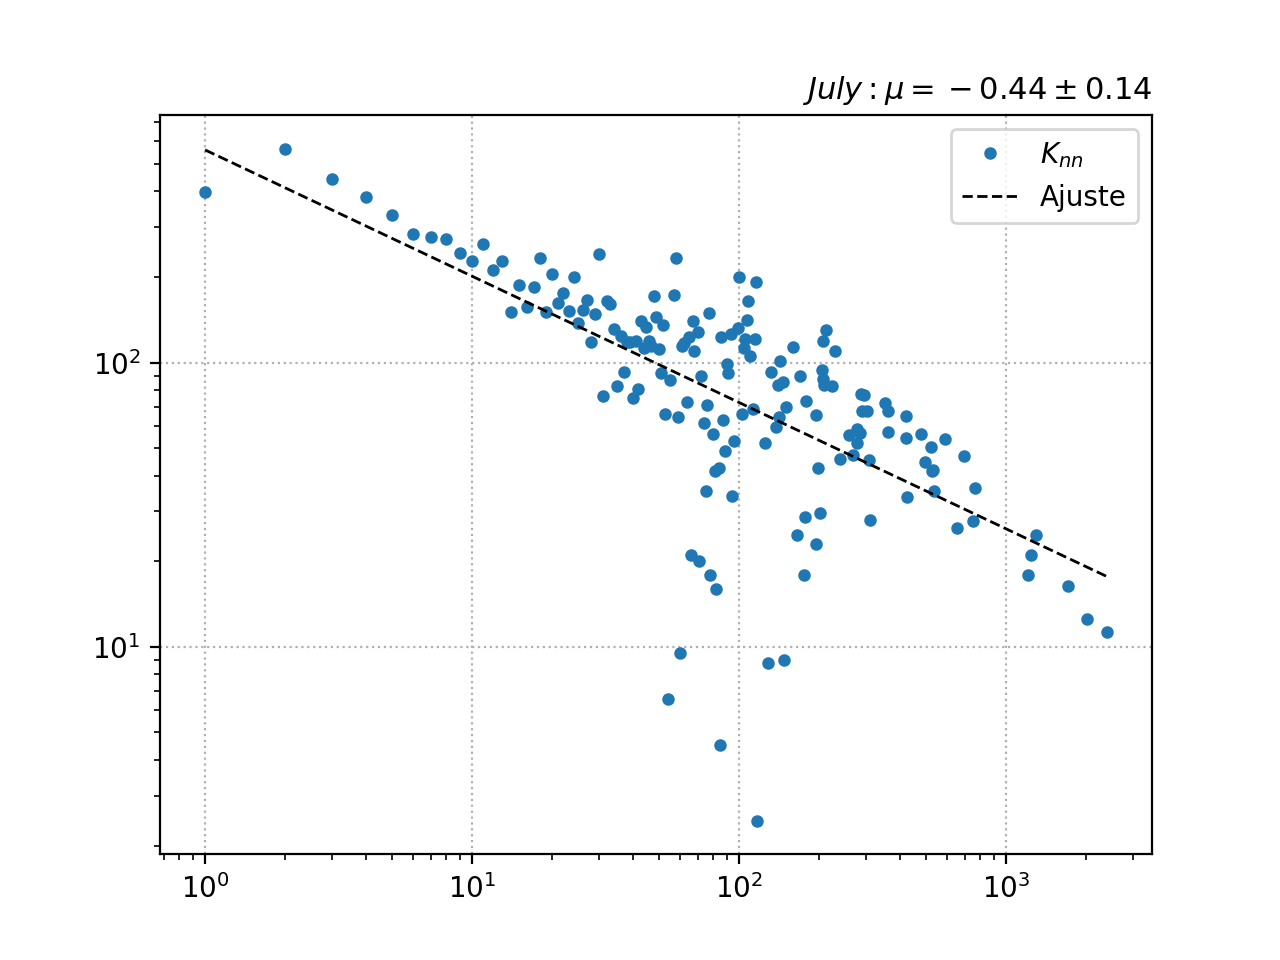

In [5]:
plt.figure(1)
plt.title(r'Netscience: $\mu= %5.2f \pm %5.2f$' %(a_net, a_err_net),loc='right',fontsize=11)
plt.loglog(k_net[8],knn_net[8],marker='d',color='c',markersize=7,label=r'$K_{max}$')
plt.loglog(k_net,knn_net,'.',markersize=7,label='$K_{nn}$')
plt.loglog(ejex_net,powerlaw(ejex_net,C_net,a_net),'k--',linewidth=1,label='Ajuste')
plt.legend()
plt.grid(linestyle=':')

plt.figure(2)
plt.title(r'$July: \mu= %5.2f \pm %5.2f$' %(a_july, a_err_july),loc='right',fontsize=11)
plt.loglog(k_july,knn_july,'.',markersize=7,label='$K_{nn}$')
plt.loglog(ejex_july,powerlaw(ejex_july,C_july,a_july),'k--',linewidth=1,label='Ajuste')
plt.legend()
plt.grid(linestyle=':')

plt.show()

### Coeficiente de correlación
Siguiendo las ecuaciones 8.26 - 8.29 del libro 'Networks, an introduction. M.E.J. Newman', escribimos la función * asort_Newman(graph)*

$$r = \dfrac{S_{1}S_{e}-S_{2}^{2}}{S_{1}S_{3}-S_{2}^{2}},$$

donde $\hspace{0.5cm}$ $S_{1} = \sum_{i,j}k_{i}$, $\hspace{0.5cm}$ $S_{2}=\sum_{i}k_{i}^{2}$, $\hspace{0.5cm}$ $S_{3}=\sum_{i}k_{i}^{3}$ $\hspace{0.1cm}$ y $\hspace{0.5cm}$ $S_{e}=\sum_{i,j}=A_{i,j}k_{i}k_{j}$

In [6]:
def asort_Newman(graph):
    S1 = np.sum([ degrees(graph, node='All') ])
    S2 = np.sum([i**2 for i in degrees(graph, node='All')])
    S3 = np.sum([i**3 for i in degrees(graph, node='All')])
    Se = 0
    for n in list(graph.nodes()):
        kn = degrees(graph,node=n)
        ed = list(graph.neighbors(n))
        deg_ed = np.sum([degrees(graph, node=i)*kn for i in ed])
        Se += deg_ed
    r = (S1*Se-S2**2)/(S1*S3-S2**2)
    return r

r_net = asort_Newman(netscience)
r_july = asort_Newman(july)


In [7]:
import pandas as pd

r = [round(r_net,3),round(r_july,3)]
a = [round(a_net,3),round(a_july,3)]

caract = pd.DataFrame({ 'Red':['Netscience','July'], 
                        '$r$':r,
                        '$\mu$':a,
                      })

caract = caract[['Red','$r$','$\mu$']]

display(caract)

,Red,$r$,$\mu$
0,Netscience,0.462,0.532
1,July,-0.198,-0.444


El estadístico $r$ toma valores del rango (-1,1), donde para $r>0$ las redes son asortativas. Por lo tanto, este estadístico predice que la red _Netscience_ es asortativa, coincidiendo con el ajuste de la función $k_{nn}(k)$, que indica que los nodos de grado alto están enlacados con nodos con la misma característica, dado que esta $k_{nn}$ posee una pendiente positiva.

Por otro lado, el gráfico $k_{nn}$ de la red _July_ indica que la misma es disortativa, dado que $k_{nn}$ disminuye con $k$. El coeficiente $r \sim-1\cdot10^{-7}$ predice que la misma es no asortativa (un valor negativo, distinto de cero está relacionado con redes disortativas)